In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal Retrieval Augmented Generation (RAG) using Vertex AI Gemini API

| | |
|-|-|
|Author(s) | [Adam Katab](https://github.com/adamgeraldy) (forking from [Lavi Nigam](https://github.com/lavinigam-gcp)) |

## Overview

Retrieval augmented generation (RAG) has become a popular paradigm for enabling LLMs to access external data and also as a mechanism for grounding to mitigate against hallucinations.

In this notebook, you will learn how to perform multimodal RAG where you will perform Q&A over a financial document filled with both text and images.

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini 1.0 Pro Vision and Gemini 1.0 Pro models.

### Comparing text-based and multimodal RAG

Multimodal RAG offers several advantages over text-based RAG:

1. **Enhanced knowledge access:** Multimodal RAG can access and process both textual and visual information, providing a richer and more comprehensive knowledge base for the LLM.
2. **Improved reasoning capabilities:** By incorporating visual cues, multimodal RAG can make better informed inferences across different types of data modalities.

This notebook shows you how to use RAG with Vertex AI Gemini API, [text embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings), and [multimodal embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/multimodal-embeddings), to build a document search engine.

Through hands-on examples, you will discover how to construct a multimedia-rich metadata repository of your document sources, enabling search, comparison, and reasoning across diverse information streams.

### Objectives

This notebook provides a guide to building a document search engine using multimodal retrieval augmented generation (RAG), step by step:

1. Extract and store metadata of documents containing both text and images, and generate embeddings the documents
2. Search the metadata with text queries to find similar text or images
3. Search the metadata with image queries to find similar images
4. Using a text query as input, search for contextual answers using both text and images

## Getting Started


### Install Vertex AI SDK for Python and other dependencies


In [2]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf rich colorama

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [3]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Define Google Cloud project information


In [1]:
# Define project information

import sys

LOCATION = "us-central1"  # @param {type:"string"}

import subprocess

PROJECT_ID = subprocess.check_output(
    ["gcloud", "config", "get-value", "project"], text=True
).strip()

print(f"Your project ID is: {PROJECT_ID}")

Your project ID is: qwiklabs-gcp-02-9e826ee50038


In [2]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [3]:
from IPython.display import Markdown, display
from rich.markdown import Markdown as rich_Markdown
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)

### Load the Gemini 1.5 Pro and Gemini 1.5 Flash models

In [4]:
text_model = GenerativeModel("gemini-1.5-pro")
multimodal_model = GenerativeModel("gemini-1.5-pro-001")
multimodal_model_flash = GenerativeModel("gemini-1.5-flash-001")

## Building metadata of documents containing text and images

### The data

There are three documents provided and to be used in this notebook:

The European Union Guidelines on Good Manufacture Practice specific to Advanced Therapy Medicinal Products

Draft Guidance for Industry: Potency Assurance for Cellular and Gene Therapy Products

Paper: Genetics of Obesity in East Asians

### Import helper functions to build metadata

Before building the multimodal RAG system, it's important to have metadata of all the text and images in the document. For references and citations purposes, the metadata should contain essential elements, including page number, file name, image counter, and so on. Hence, as a next step, you will generate embeddings from the metadata, which will is required to perform similarity search when querying the data.

In [5]:
from intro_multimodal_rag_utils import get_document_metadata

### Extract and store metadata of text and images from a document

You just imported a function called `get_document_metadata()`. This function extracts text and image metadata from a document, and returns two dataframes, namely *text_metadata* and *image_metadata*, as outputs. If you want to find out more about how `get_document_metadata()` function is implemented using Gemini and the embedding models, you can take look at the [source code](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py) directly.

The reason for extraction and storing both text metadata and image metadata is that just by using either of the two alone is not sufficient to come out with a relevent answer. For example, the relevant answers could be in visual form within a document, but text-based RAG won't be able to take into consideration of the visual images. You will also be exploring this example later in this notebook.


At the next step, you will use the function to extract and store metadata of text and images froma document. Please note that the following cell may take a few minutes to complete:

Note:

The current implementation works best:

* if your documents are a combination of text and images.
* if the tables in your documents are available as images.
* if the images in the document don't require too much context.

Additionally,

* If you want to run this on text-only documents, use normal RAG
* If your documents contain particular domain knowledge, pass that information in the prompt below.

In [6]:
%%time
# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "docs/Med Journal/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
If the image has text in it, list all the text as well, and explain it if possible.
Do not include any numbers that are not mentioned in the image. Do not include any other elements that are not available in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing Gemini 1.5 Pro model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- docs/Med Journal/2023-378_potency_draft_guidance_document_12-27-2023.pdf 


Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processing page: 8
Processing page: 9
Processing page: 10
Processing page: 11
Processing page: 12
Processing page: 13
Processing page: 14
Processing page: 15
Processing page: 16
Processing page: 17
Processing page: 18
Processing page: 19
Processing page: 20
Processing page: 21
Processing page: 22
Processing page: 23
Processing page: 24
Processing page: 25
Processing page: 26
Processing page: 27


 Processing the file: --------------------------------- docs/Med Journal/2017_11_22_guidelines_gmp_for_atmps.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/2017_11_22_guidelines_gmp_for_atmps.pdf_image_0_0_3.png
Processing page: 2
Extracting image from page: 2, saved as: images/2017_11_22_guidelines_gmp_f

In [ ]:
# # Parameters for Gemini API call.
# # reference for parameters: https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/gemini

# generation_config=  GenerationConfig(temperature=0.2, max_output_tokens=2048)

# # Set the safety settings if Gemini is blocking your content or you are facing "ValueError("Content has no parts")" error or "Exception occurred" in your data.
# # ref for settings and thresholds: https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/configure-safety-attributes

# safety_settings = {
#                   HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
#                   }

# # You can also pass parameters and safety_setting to "get_gemini_response" function

#### Inspect the processed text metadata


The following cell will produce a metadata table which describes the different parts of text metadata, including:

- **text**: the original text from the page
- **text_embedding_page**: the embedding of the original text from the page
- **chunk_text**: the original text divided into smaller chunks
- **chunk_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [7]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,2023-378_potency_draft_guidance_document_12-27...,1,\n \n \n \nPotency Assurance for Cellular and...,"[0.006886777002364397, -0.0176057368516922, -0...",1,\n \n \n \nPotency Assurance for Cellular and...,"[0.004837428219616413, -0.018241185694932938, ..."
1,2023-378_potency_draft_guidance_document_12-27...,1,\n \n \n \nPotency Assurance for Cellular and...,"[0.006886777002364397, -0.0176057368516922, -0...",2,"or by calling 1-800-835-4709 or 240-402-8010, ...","[-0.008827504701912403, -0.031592052429914474,..."
2,2023-378_potency_draft_guidance_document_12-27...,2,Contains Nonbinding Recommendations \n \nDraft...,"[-0.013453412801027298, -0.06196395307779312, ...",1,Contains Nonbinding Recommendations \n \nDraft...,"[0.007208812981843948, -0.06884723156690598, -..."
3,2023-378_potency_draft_guidance_document_12-27...,2,Contains Nonbinding Recommendations \n \nDraft...,"[-0.013453412801027298, -0.06196395307779312, ...",2,. \nQuality Risk Management and Assurance of P...,"[-0.022518174722790718, -0.06263156980276108, ..."
4,2023-378_potency_draft_guidance_document_12-27...,2,Contains Nonbinding Recommendations \n \nDraft...,"[-0.013453412801027298, -0.06196395307779312, ...",3,...................... 16 \nA. \nUses of Poten...,"[-0.005424581002444029, -0.05647880211472511, ..."


#### Inspect the processed image metadata

The following cell will produce a metadata table which describes the different parts of image metadata, including:
* **img_desc**: Gemini-generated textual description of the image.
* **mm_embedding_from_text_desc_and_img**: Combined embedding of image and its description, capturing both visual and textual information.
* **mm_embedding_from_img_only**: Image embedding without description, for comparison with description-based analysis.
* **text_embedding_from_image_description**: Separate text embedding of the generated description, enabling textual analysis and comparison.

In [8]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,2017_11_22_guidelines_gmp_for_atmps.pdf,1,1,images/2017_11_22_guidelines_gmp_for_atmps.pdf...,The image is the flag of the European Union. I...,"[-0.0043147183, 0.0789211839, 0.0103896903, -0...","[0.023461198434233665, -0.06470965594053268, -..."
1,gwas asia vs european.pdf,9,1,images/gwas asia vs european.pdf_image_8_0_820...,The image is a Venn diagram showing the overla...,"[0.0172956511, 0.0378183089, -0.0203739367, 0....","[-0.024591561406850815, -0.03276338800787926, ..."
2,gwas asia vs european.pdf,10,1,images/gwas asia vs european.pdf_image_9_0_847...,The image is a graph.\n\nThe graph is a scatte...,"[0.0110858055, 0.0319211036, -0.00727906916, 0...","[0.01540002878755331, -0.03562198579311371, -0..."
3,gwas asia vs european.pdf,11,1,images/gwas asia vs european.pdf_image_10_0_86...,The image is a graph comparing the effect size...,"[0.0245084018, 0.0135550043, -0.0142692393, 0....","[-0.017453430220484734, -0.05952855199575424, ..."


In [9]:
image_metadata_df.img_desc[2]

'The image is a graph.\n\nThe graph is a scatter plot showing the distribution of a variable, represented by the Greek letter Beta (β), for two groups: Asian and European. Each dot represents an individual data point. \n\nThe European group shows a wider range of Beta values compared to the Asian group. The European group also has more data points at higher Beta values. \n'

In [10]:
image_metadata_df.text_embedding_from_image_description[2]

[0.01540002878755331,
 -0.03562198579311371,
 -0.04324515908956528,
 0.011861527338624,
 0.06344208866357803,
 -0.008327820338308811,
 0.027038875967264175,
 -0.020080674439668655,
 -0.027127735316753387,
 0.029118234291672707,
 0.04836641624569893,
 0.03425608575344086,
 -0.06810265779495239,
 -0.006856411695480347,
 0.043875355273485184,
 -0.020346125587821007,
 0.009489125572144985,
 -0.006038466468453407,
 0.017576230689883232,
 -0.022716132923960686,
 0.031187018379569054,
 0.007960028015077114,
 0.01710158959031105,
 -0.028282318264245987,
 0.018140800297260284,
 -0.04209774360060692,
 -0.00414265226572752,
 -0.03283446282148361,
 0.009256076067686081,
 0.006035842467099428,
 -0.05637572705745697,
 0.005416044499725103,
 -0.07928045094013214,
 0.0046944753266870975,
 -0.006167467683553696,
 -0.033360034227371216,
 0.02722514420747757,
 -0.02655881829559803,
 0.023905891925096512,
 0.03320061415433884,
 -0.030279863625764847,
 -0.026114080101251602,
 -0.013104913756251335,
 -0.003

### Import the helper functions to implement RAG

You will be importing the following functions which will be used in the remainder of this notebook to implement RAG:

* **get_similar_text_from_query():** Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
* **print_text_to_text_citation():** Prints the source (citation) and details of the retrieved text from the `get_similar_text_from_query()` function.
* **get_similar_image_from_query():** Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
* **print_text_to_image_citation():** Prints the source (citation) and the details of retrieved images from the `get_similar_image_from_query()` function.
* **get_gemini_response():** Interacts with a Gemini model to answer questions based on a combination of text and image inputs.
* **display_images():**  Displays a series of images provided as paths or PIL Image objects.

In [11]:
from intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

Before implementing a multimodal RAG, let's take a step back and explore what you can achieve with just text or image embeddings alone. It will help to set the foundation for implementing a multimodal RAG, which you will be doing in the later part of the notebook. You can also use these essential elements together to build applications for multimodal use cases for extracting meaningful information from the document.

## Text Search

Let's start the search with a simple question and see if the simple text search using text embeddings can answer it.


In [12]:
query = "What is GWAS?"

### Search similar text with text query

In [13]:
# Matching user text query with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(matching_results_text, print_top=False, chunk_text=True)

Citation 1: Matched text:
Score: 0.77
File name: gwas asia vs european.pdf
Page: 2
Page number: 2
Chunk number: 3
Chunk text: y specic
genes but only susceptibility regions in the genome. Converting
genetic risk loci into eector transcripts and function has been
slow and has become a eld of research in itself. Also, imperfect
correlation between eect sizes measured from a population-
based approach such as GWAS and eect sizes measured from
a sibling approach suggests potentially a signicant amount of
indirect genetic eects (genetic nurture) captured in GWAS
direct eects for a trait like BMI (Young et al., 2020). It is also
noteworthy that currently established methods such as Genome-
wide Polygenic Score (GPS), which estimates heritability of
human complex traits in unrelated individuals using whole-
genome sequencing data, further evidenced a missing heritability
in BMI compared with assumptions based on earlier studies
(Khera et al., 2019). Based on the fact that most of the
previous

You can see the relevant chunks in the above output.

Let's feed the relevant text chunk across the data into the Gemini 1.5 Pro model and see if it can get your desired answer by considering all the chunks across the document. This is like basic text-based RAG implementation.

In [14]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = "\n".join(
    [value["chunk_text"] for key, value in matching_results_text.items()]
)

instruction = f"""Answer the question with the given context.
If the information is not available in the context, just return "not available in the context".
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
get_gemini_response(
    text_model,  # we are passing Gemini 1.0 Pro
    model_input=model_input,
    stream=True,
    generation_config=GenerationConfig(temperature=0.2),
)


 **** Result: ***** 



'GWAS stands for **Genome-wide association study**, as found in the phrase "In summary, GWAS has exhibited a large number of BMI-associated loci over the past decade". \n'

### Search similar images with text query

Since plain text search didn't provide the desired answer and the information may be visually represented in a table or another image format, you will use multimodal capability of Gemini 1.5 Pro Vision model for the similar task. The goal here also is to find an image similar to the text query. You may also print the citations to verify.

In [15]:
query = "List the Asian loci in reported cohorts that do not coincide with European loci"


 **** Result: ***** 



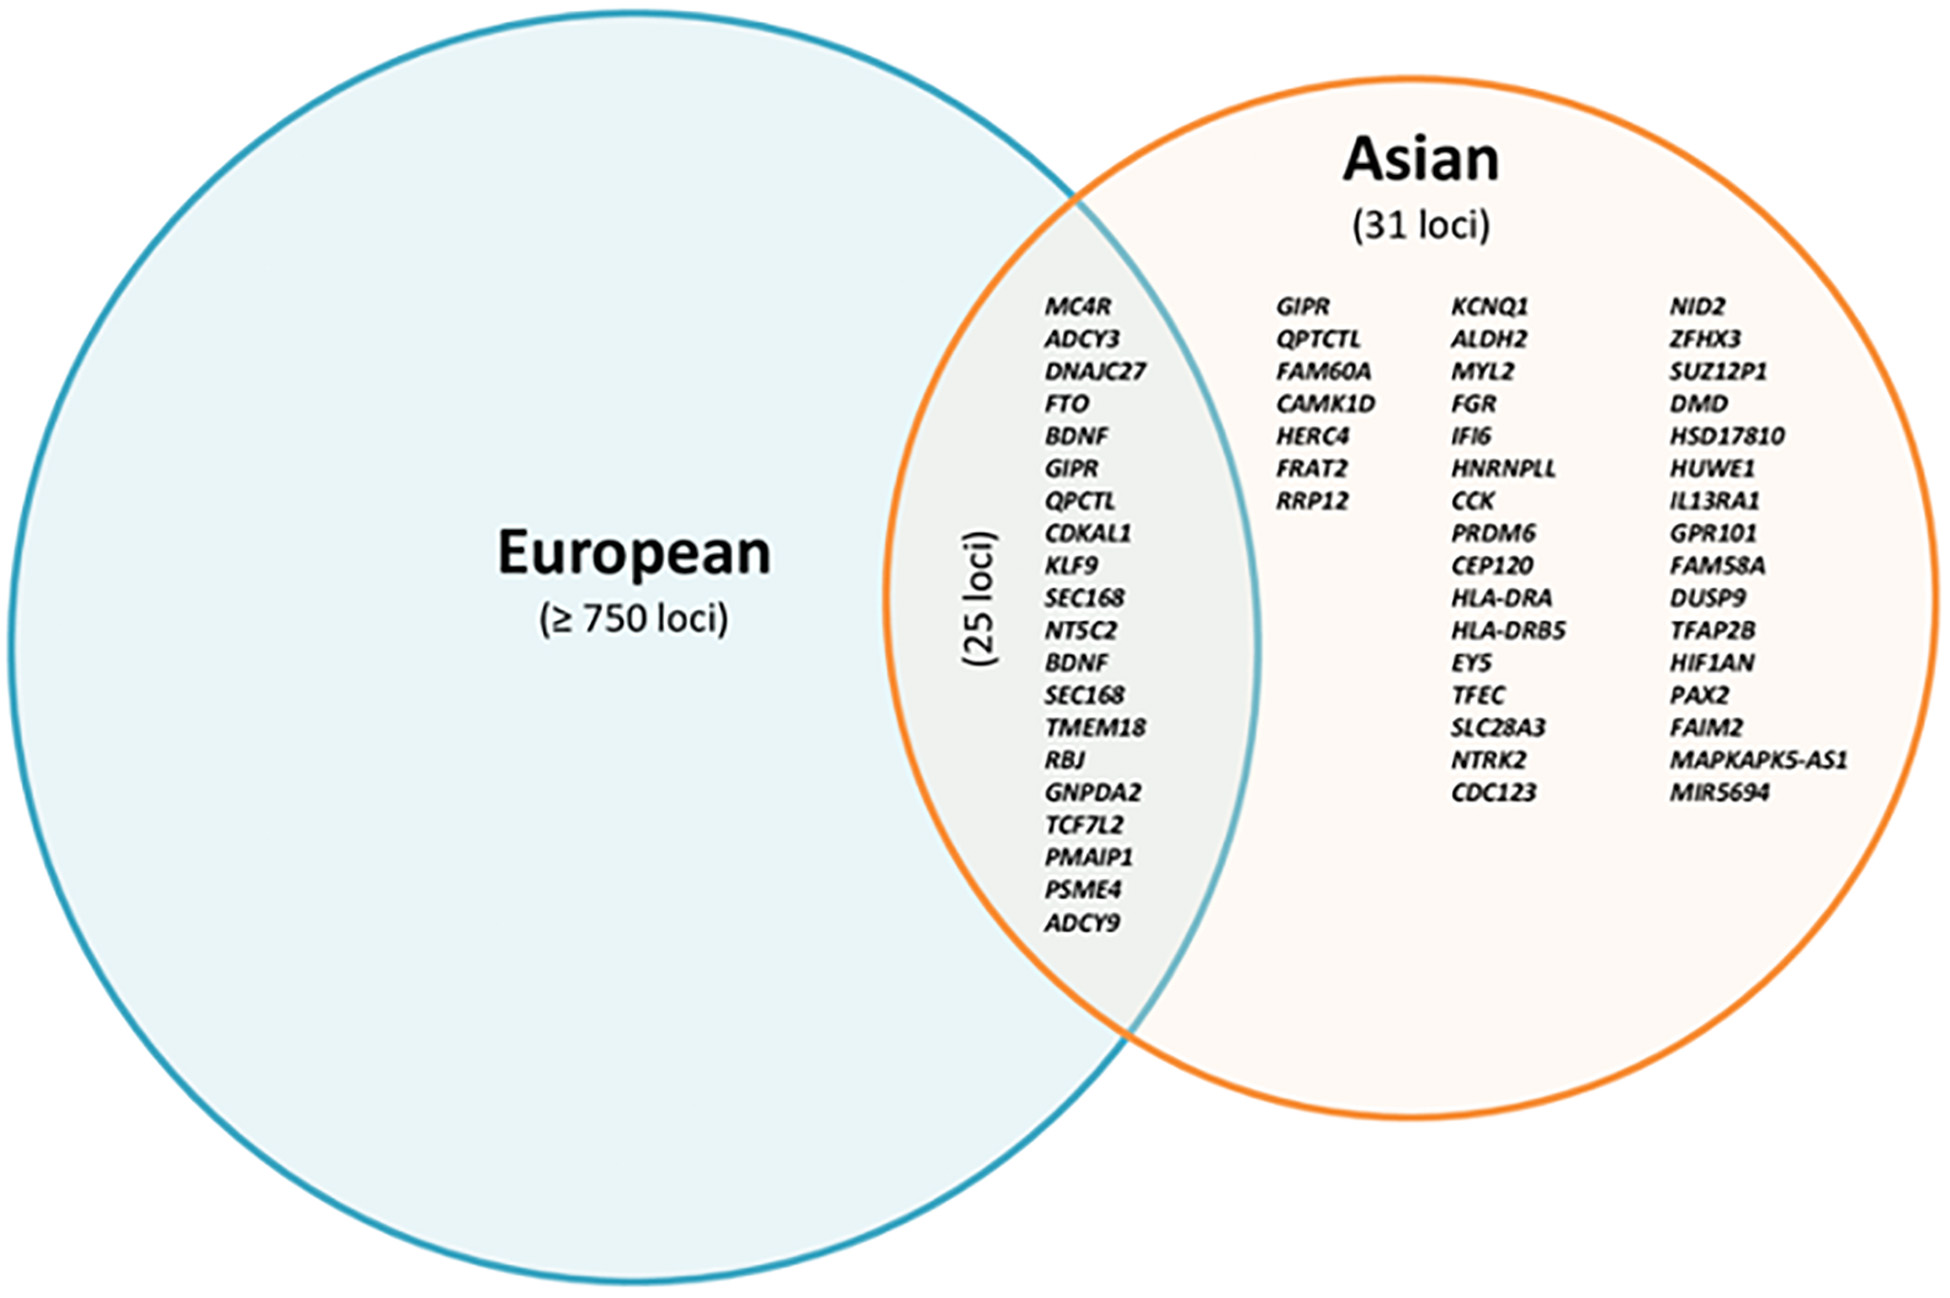

In [16]:
matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display(matching_results_image[0]["image_object"])

Bingo! It found exactly what you were looking for. This image fits the bill perfectly thanks to its descriptive metadata using Gemini.

You can also send the image and its description to Gemini 1.5 Pro Vision and get the answer as JSON:

In [17]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = f"""Image: {matching_results_image[0]['image_object']}
Description: {matching_results_image[0]['image_description']}
"""

instruction = f"""Answer the question in JSON format with the given context of Image and its Description. Only include value.
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model_flash,  # we are passing Gemini 1.5 Pro Flash
        model_input=model_input,
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)


 **** Result: ***** 



```json
[
  "ADCY3",
  "DNAJC27",
  "FTO",
  "GIPR",
  "QPCTL",
  "CDKAL1",
  "KLF9",
  "SEC168",
  "NTSC2",
  "TMEM18",
  "RBJ",
  "GNPDA2",
  "TCF7L2",
  "PMAIP1",
  "PSME4",
  "ADCY9"
]
```

In [18]:
## you can check the citations to probe further.
## check the "image description:" which is a description extracted through Gemini which helped search our query.
Markdown(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1:
Matched image path, page number, and page text:
Score: 0.77
File name: gwas asia vs european.pdf
Path: images/gwas asia vs european.pdf_image_8_0_820.png
Page number: 9
Page text: Sun et al.
Genetics of Obesity in Asians
FIGURE 1 | Overlap of reported loci associated with BMI in European and Asian cohorts based on p-value < 108.
et al., 2009). Pancreatic polypeptide Y receptor Y4 (PPYR1)
located under this CNV area appears to be a plausible gene
eventually related to obesity, and Shebanits et al. (2018) have
also found similar ndings in a Swedish cohort which suggested
an association of PPYR1 (NPY4R) with WC in women. PPYR1
is one of the receptors of pancreatic polypeptide (PP), and
several studies demonstrated that PP regulates the food intake via
PPYR1 (Batterham et al., 2003). Yang et al. (2013) conrmed the
association of a CNV on 16p12.3 with obesity-related phenotypes
in a European but not in Asian cohort and suggested G protein-
coupled receptor class C group 5 member

<IPython.core.display.Markdown object>

### Comparative reasoning

Next, let's apply what you have done so far to doing comparative reasoning.

For this example:

Step 1: You will search all the images for a specific query

Step 2: Send those images to Gemini 1.5 Pro Vision to ask multiple questions, where it has to compare and provide you with answers.

In [19]:
matching_results_image_query_1 = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query="Show me all images that contain a chart or Venn diagram",
    column_name="text_embedding_from_image_description",  # Use image description text embedding # mm_embedding_from_img_only text_embedding_from_image_description
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

---------------Matched Images------------------



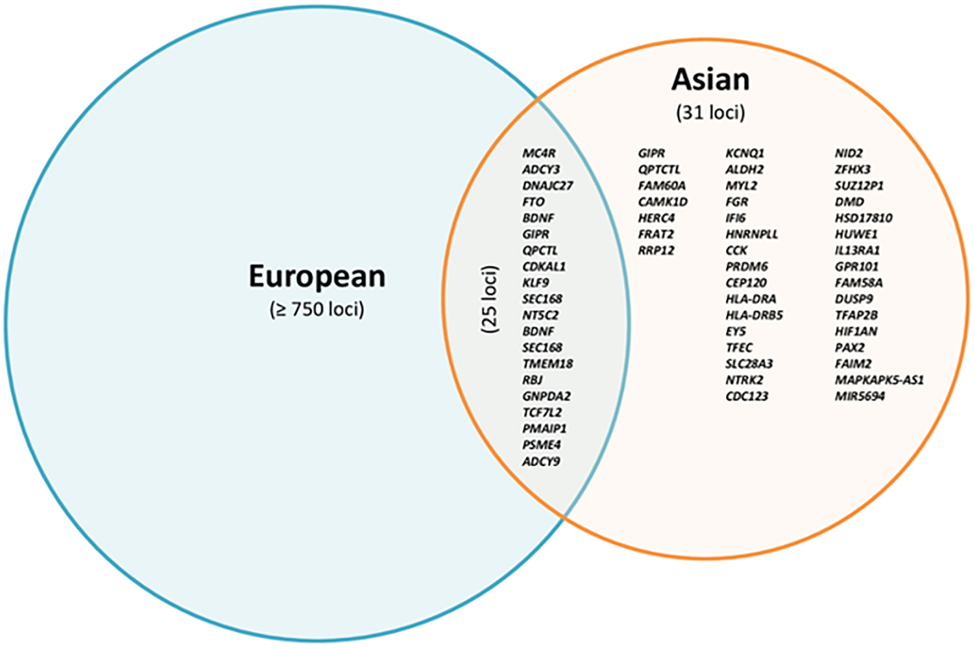

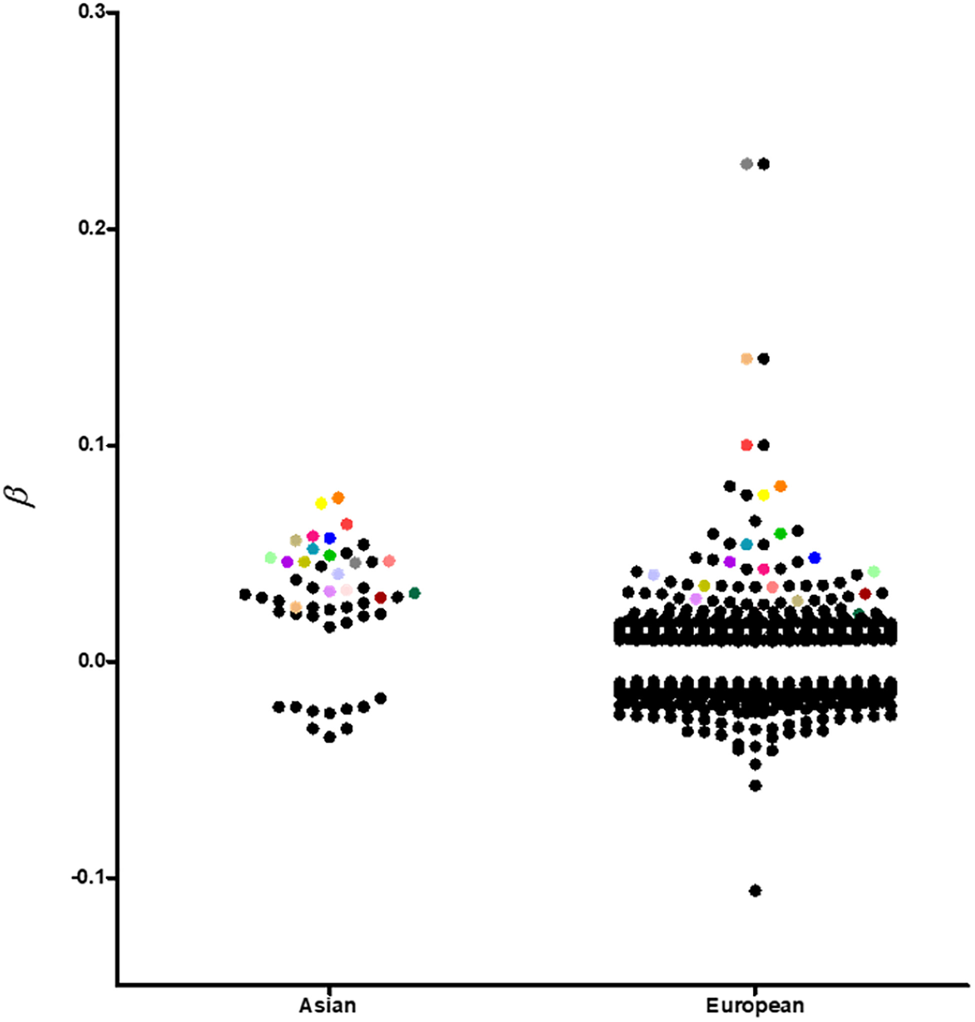

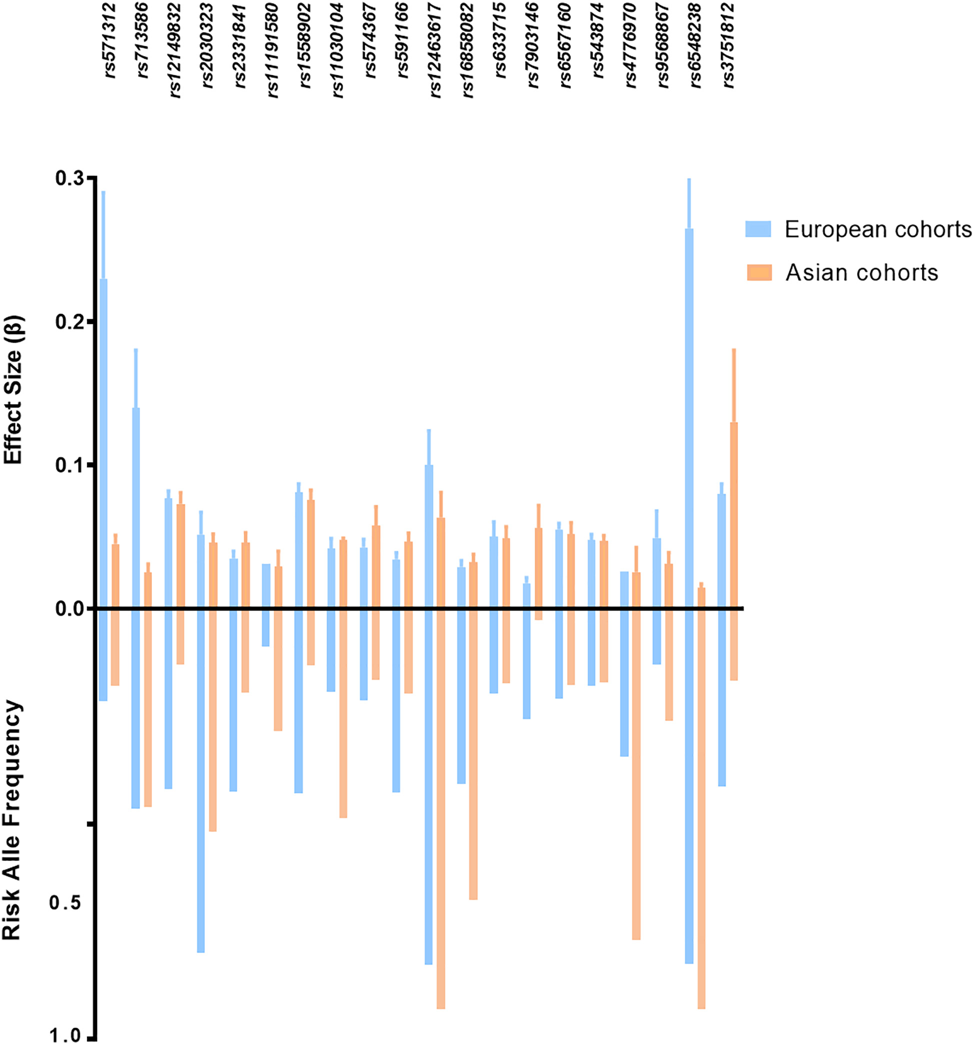

In [20]:
# Check Matched Images
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_query_1[0]["img_path"],
        matching_results_image_query_1[1]["img_path"],
        matching_results_image_query_1[2]["img_path"],
    ],
    resize_ratio=0.5,
)

In [21]:
prompt = f""" Instructions: Compare the images and the Gemini extracted text provided as Context: to answer Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.

Context:
Image_1: {matching_results_image_query_1[0]["image_object"]}
gemini_extracted_text_1: {matching_results_image_query_1[0]['image_description']}
Image_2: {matching_results_image_query_1[1]["image_object"]}
gemini_extracted_text_2: {matching_results_image_query_1[2]['image_description']}

Question:
 - Looking at the diagrams, tell me your findings and summaries
 - What are some key insights you can get from the diagrams and the images?
 - Give me a list of all the shared Asian loci & European loci?"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,  # we are passing Gemini 1.5 Pro
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=0.2),
    )
)

Findings and Summaries:                                              

 • Image 1: This Venn diagram highlights the limited overlap in genetic loci associated with BMI between European  
   and Asian populations. While Europeans have at least 750 identified loci, Asians have only 31, with a mere 25   
   shared between them. This suggests that genetic predisposition to BMI differs significantly between these       
   populations.                                                                                                    
 • Image 2: This graph delves deeper into the shared loci by comparing the effect size and risk allele frequency of
   specific genetic variants (rsIDs) in European and Asian cohorts. It reveals that even for shared variants, the  
   impact on BMI (effect size) and prevalence within the population (risk allele frequency) can differ             
   significantly.                                                                                                  


                                                   Key Insights:                                                   

 • Genetic architecture of complex traits: BMI, like many complex traits, is influenced by numerous genes. The     
   diagrams demonstrate that this genetic architecture can vary significantly between populations, even those with 
   shared ancestry.                                                                                                
 • Ethnicity in genetic studies:  The findings underscore the importance of considering ethnicity in genetic       
   studies. Generalizing findings from one population to another can be misleading, as the genetic basis for a     
   trait may differ.                                                                                               
 • Personalized medicine: Understanding population-specific genetic influences on traits like BMI is crucial for   
   developing tailored interventions and personalized medicine approaches.                                         


                                                   Shared Loci:                                                    

The question asks for a list of "shared Asian loci & European loci," but this phrasing is slightly misleading.  All
the listed loci are shared between the two populations.  Here's the list from the Venn diagram:                    

 • MC4R                                                                                                            
 • ADCY3                                                                                                           
 • DNAJC27                                                                                                         
 • FTO                                                                                                             
 • BDNF                                                                                                            
 • GIPR                                                                                                            
 • QPCTL                                                                                                           
 • CDKAL1                                                                                                          
 • KLF9                                                                                                            
 • SEC168                                                                                                          
 • NTSC2                                                                                                           
 • BDNF                                                                                                            
 • SEC168                                                                                                          
 • TMEM18                                                                                     

## Multimodal retrieval augmented generation (RAG)

Let's bring everything together to implement multimodal RAG. You will use all the elements that you've explored in previous sections to implement the multimodal RAG. These are the steps:

* **Step 1:** The user gives a query in text format where the expected information is available in the document and is embedded in images and text.
* **Step 2:** Find all text chunks from the pages in the documents using a method similar to the one you explored in `Text Search`.
* **Step 3:** Find all similar images from the pages based on the user query matched with `image_description` using a method identical to the one you explored in `Image Search`.
* **Step 4:** Combine all similar text and images found in steps 2 and 3 as `context_text` and `context_images`.
* **Step 5:** With the help of Gemini, we can pass the user query with text and image context found in steps 2 & 3. You can also add a specific instruction the model should remember while answering the user query.
* **Step 6:** Gemini produces the answer, and you can print the citations to check all relevant text and images used to address the query.

### Step 1: User query

In [22]:
# this time we are not passing any images, but just a simple text query.

query = """Questions:
- Ada berapa loci yang shared antara Asian dan European terkait BMI?
- Apa alasan potensial di balik perbedaan frekuensi alel risiko untuk lokus BMI yang sama antara populasi Asia dan Eropa?                                                                                                          
- Bagaimana peneliti mengidentifikasi dan memvalidasi lokus BMI spesifik-leluhur dalam studi multi-etnis/trans-etnis?                                                                                        
- Apa saja kelemahan penggunaan BMI sebagai ukuran obesitas dalam studi genetik, dan alternatif potensial apa yang disarankan?                                                                                                     
- Berapa proporsi varians fenotipik BMI yang dijelaskan oleh 31 lokus yang terkait GWAS dalam kohort Asia?        
- Apa implikasi dari penemuan lokus BMI spesifik-leluhur untuk pengembangan strategi pencegahan dan pengobatan obesitas yang dipersonalisasi?
"""

### Step 2: Get all relevant text chunks

In [23]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

### Step 3: Get all relevant images

In [24]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

### Step 4: Create context_text and context_images

In [25]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

### Step 5: Pass context to Gemini

In [26]:
prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}

{query}

Answer:
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=0.2),
    )
)

Berikut adalah jawaban atas pertanyaan Anda berdasarkan konteks yang diberikan:                                    

- Ada berapa loci yang shared antara Asian dan European terkait BMI?                                               

 • Langkah 1: Lihat keterangan Gambar pertama.                                                                     
 • Langkah 2:  Identifikasi daerah yang tumpang tindih antara lingkaran "European" dan "Asian".                    
 • Langkah 3:  Keterangan pada daerah tumpang tindih menunjukkan jumlah loci yang shared.                          

Jawaban: Ada 25 loci yang shared antara populasi Asia dan Eropa terkait BMI.                                       

- Apa alasan potensial di balik perbedaan frekuensi alel risiko untuk lokus BMI yang sama antara populasi Asia dan 
Eropa?                                                                                                             

 • Langkah 1:  Baca dengan seksama konteks teks yang diberikan, terutama bagian yang membahas perbedaan genetik    
   antara populasi.                                                                                                

Jawaban:  Teks tersebut menyebutkan beberapa alasan potensial untuk perbedaan frekuensi alel risiko: *             
Heterogenitas genetik:  Latar belakang genetik yang berbeda antara populasi dapat menyebabkan varian genetik yang  
berbeda terkait dengan BMI. * Ekspresi fenotipik yang berbeda:  Faktor lingkungan dan gaya hidup dapat memengaruhi 
bagaimana gen diekspresikan, yang mengarah pada perbedaan kerentanan terhadap obesitas. * Sejarah evolusi yang     
berbeda: Populasi yang berevolusi di lingkungan yang berbeda mungkin telah mengalami tekanan seleksi yang berbeda, 
yang menyebabkan perbedaan frekuensi varian genetik terkait BMI.                                                   

- Bagaimana peneliti mengidentifikasi dan memvalidasi lokus BMI spesifik-leluhur dalam studi                       
multi-etnis/trans-etnis?                                                                                           

 • Langkah 1:  Cari bagian dalam teks yang membahas studi multi-etnis/trans-etnis.                                 

Jawaban: Teks tersebut menjelaskan bahwa studi multi-etnis/trans-etnis memungkinkan peneliti untuk: *              
Mengidentifikasi varian genetik umum yang terkait dengan BMI di berbagai leluhur. * Menemukan varian predisposisi  
penyakit spesifik-leluhur yang unik untuk populasi tertentu. * Membedakan efek varian genetik dalam konteks latar  
belakang leluhur yang berbeda.                                                                                     

Peneliti dapat menggunakan teknik statistik untuk mengontrol struktur populasi dan mengidentifikasi lokus yang     
terkait dengan BMI dalam kelompok leluhur tertentu. Validasi biasanya melibatkan replikasi temuan dalam kohort     
independen dari leluhur yang sama.                                                                                 

- Apa saja kelemahan penggunaan BMI sebagai ukuran obesitas dalam studi genetik, dan alternatif potensial apa yang 
disarankan?                                                                                                        

 • Langkah 1:  Temukan bagian dalam teks yang mengkritik penggunaan BMI sebagai ukuran obesitas.                   

Jawaban: Teks tersebut menyoroti kelemahan berikut dari penggunaan BMI: * BMI tidak membedakan antara massa lemak  
dan massa otot, yang dapat menghasilkan klasifikasi obesitas yang tidak akurat, terutama pada populasi dengan      
komposisi tubuh yang berbeda. * BMI mungkin bukan ukuran obesitas yang paling tepat secara global, karena tidak    
memperhitungkan variasi komposisi tubuh antar populasi.                                                            

Teks tersebut menyarankan alternatif potensial berikut: * Pemindaian MRI seluruh tubuh: Memberikan pengukuran      
komposisi tubuh yang lebih akurat, termasu

### Step 6: Print citations and references

---------------Matched Images------------------



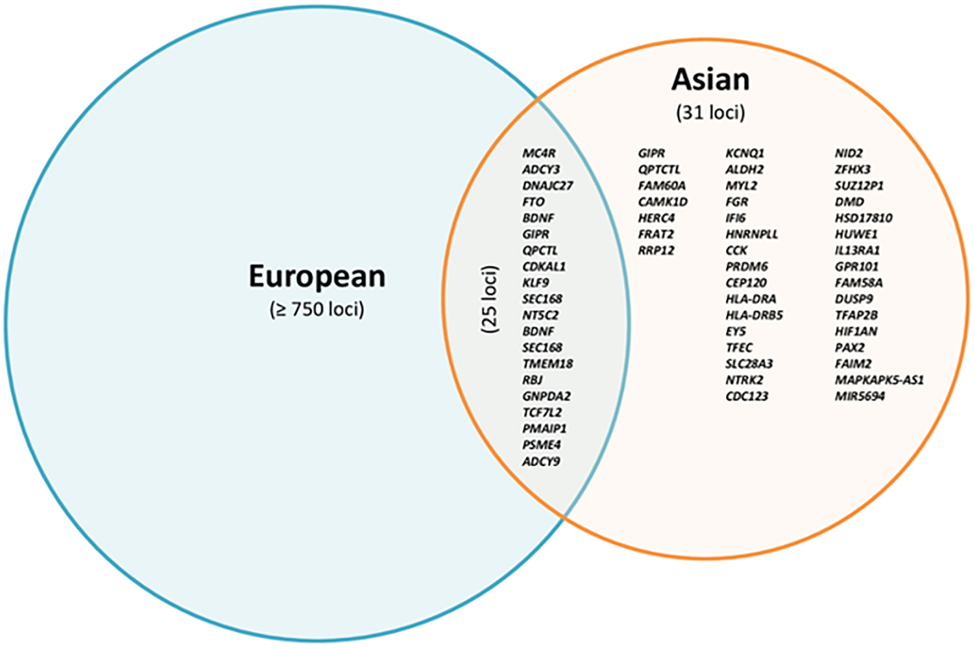

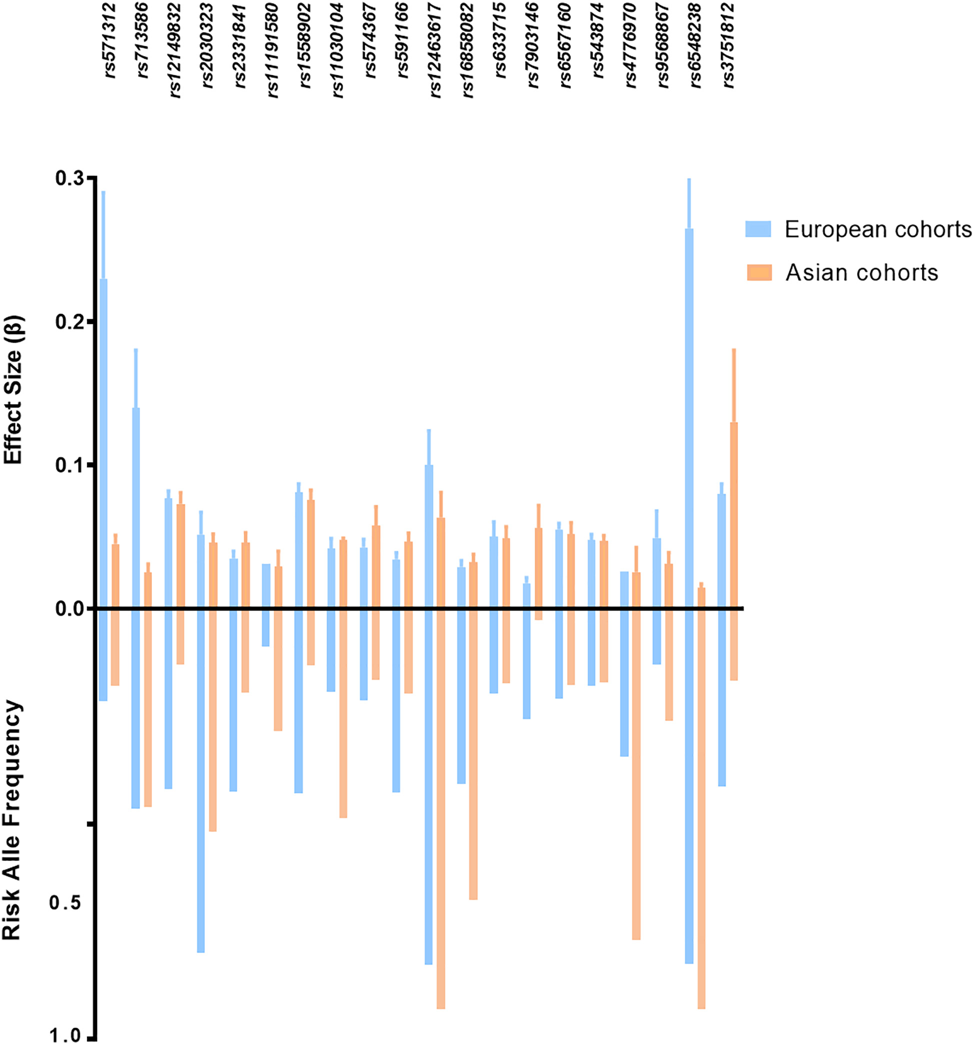

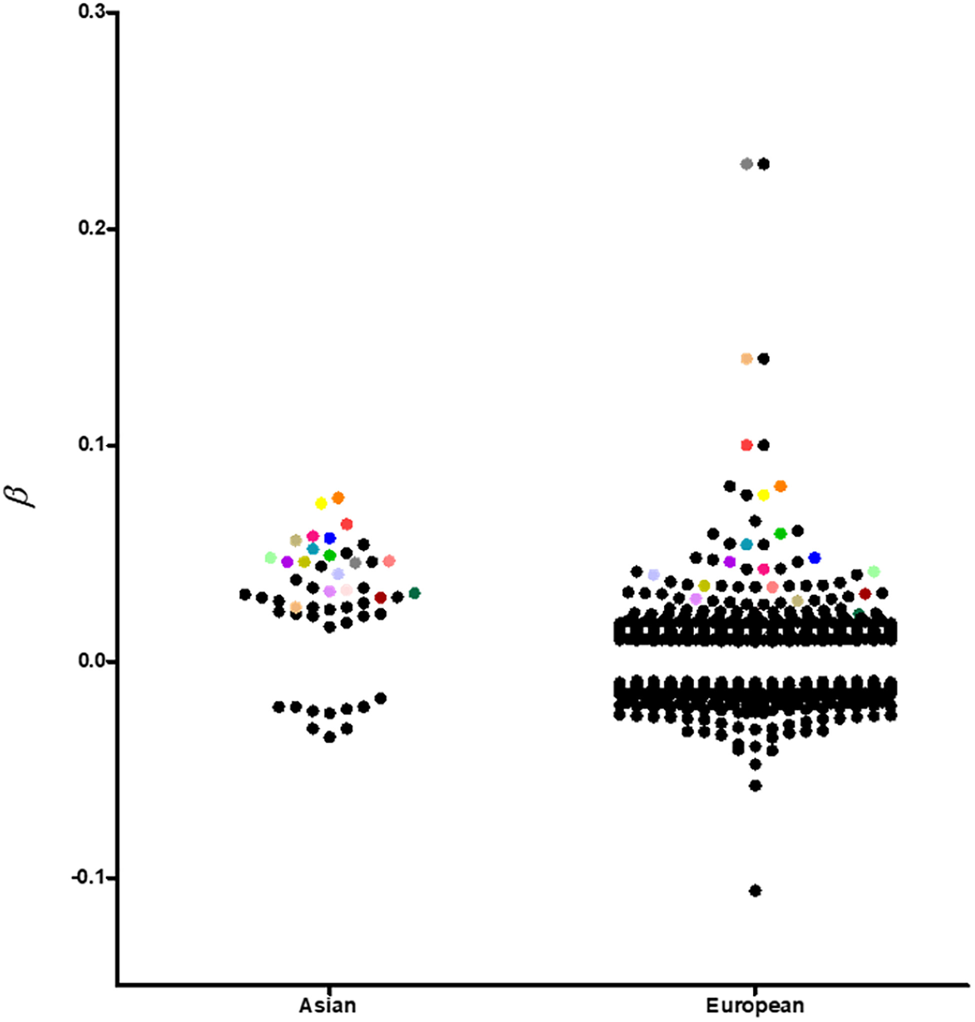

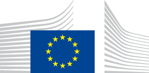

In [27]:
print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_fromdescription_data[0]["img_path"],
        matching_results_image_fromdescription_data[1]["img_path"],
        matching_results_image_fromdescription_data[2]["img_path"],
        matching_results_image_fromdescription_data[3]["img_path"],
    ],
    resize_ratio=0.5,
)

In [28]:
# Image citations. You can check how Gemini generated metadata helped in grounding the answer.

print_text_to_image_citation(
    matching_results_image_fromdescription_data, print_top=False
)

Citation 1:
Matched image path, page number, and page text:
Score: 0.77
File name: gwas asia vs european.pdf
Path: images/gwas asia vs european.pdf_image_8_0_820.png
Page number: 9
Page text: Sun et al.
Genetics of Obesity in Asians
FIGURE 1 | Overlap of reported loci associated with BMI in European and Asian cohorts based on p-value < 108.
et al., 2009). Pancreatic polypeptide Y receptor Y4 (PPYR1)
located under this CNV area appears to be a plausible gene
eventually related to obesity, and Shebanits et al. (2018) have
also found similar ndings in a Swedish cohort which suggested
an association of PPYR1 (NPY4R) with WC in women. PPYR1
is one of the receptors of pancreatic polypeptide (PP), and
several studies demonstrated that PP regulates the food intake via
PPYR1 (Batterham et al., 2003). Yang et al. (2013) conrmed the
association of a CNV on 16p12.3 with obesity-related phenotypes
in a European but not in Asian cohort and suggested G protein-
coupled receptor class C group 5 member

In [29]:
# Text citations

print_text_to_text_citation(
    matching_results_chunks_data,
    print_top=False,
    chunk_text=True,
)

Citation 1: Matched text:
Score: 0.84
File name: gwas asia vs european.pdf
Page: 7
Page number: 7
Chunk number: 6
Chunk text: et al., 2013).
By reviewing all current BMI-related studies in Asian cohorts
(Table 1), we found 92 loci (Supplementary Table S1) and
compared them with GWAS in European cohorts. Forty-two of
92 BMI-related loci have been previously reported in European
cohorts with p < 5  108 and had a consistent direction
of eect on BMI. For the remaining 50 BMI-related loci, we
observed no compelling evidence of replication (Supplementary
Table S1). According to our dened criteria (p < 5  108 for
GWAS, p < 0.05 for replication), the replications failed in the
following cases: (1) 6 of 50 SNPs reached the genome signicant
p-value (p < 5  108) in Asian cohorts but not in European
cohorts. Because it is unlikely that limited statistical power due
to small sample size and minor allele frequencies would be
a crucial factor (see Supplementary Table S1) explaining the
failed replica

### Part 2
### Step 1: User query

In [30]:
# this time we are not passing any images, but just a simple text query.

query = """Questions:
- Bagaimana EU Guidelines for ATMP menyeimbangkan kebutuhan akan inovasi dalam terapi pengobatan canggih dengan kebutuhan untuk memastikan keamanan dan kemanjuran pasien?
- Bagaimana EU Guidelines for ATMP mengatasi tantangan unik yang ditimbulkan oleh pengembangan dan penggunaan terapi gen dan sel, khususnya yang berkaitan dengan imunogenisitas dan potensi integrasi genom?
- Bagaimana EU Guidelines for ATMP difaktorkan dalam perkembangan ilmiah dan teknologi dalam pengobatan regeneratif, seperti penggunaan pengeditan gen dan organoid?
- Bagaimana EU Guidelines for ATMP memengaruhi akses pasien ke ATMP, khususnya dalam konteks keterjangkauan dan ketersediaan?
- Bagaimana EU Guidelines for ATMP selaras dengan peraturan internasional dan pedoman mengenai ATMP, dan apa implikasi dari harmonisasi ini untuk pengembangan dan penyebaran ATMP secara global?
- Berikan saya 5 pertanyaan menarik soal Draft Guidance for Industry, Potency Assurance for Cellular and Gene Therapy Products
"""

### Step 2: Get all relevant text chunks

In [31]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

### Step 3: Get all relevant images

In [32]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

### Step 4: Create context_text and context_images

In [33]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

### Step 5: Pass context to Gemini

In [34]:
prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}

{query}

Answer:
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=0.2),
    )
)

Berikut adalah jawaban atas pertanyaan Anda, yang disusun berdasarkan konteks yang Anda berikan:                   


                                                Jawaban Pertanyaan:                                                

1. Bagaimana EU Guidelines for ATMP menyeimbangkan kebutuhan akan inovasi dalam terapi pengobatan canggih dengan   
kebutuhan untuk memastikan keamanan dan kemanjuran pasien?                                                         

EU Guidelines for ATMP menyeimbangkan kebutuhan akan inovasi dan keamanan pasien melalui beberapa cara:            

 • Fleksibilitas dalam pendekatan: Pedoman ini mengakui keragaman dan kompleksitas ATMP, sehingga menawarkan       
   fleksibilitas dalam penerapan persyaratan GMP. Hal ini memungkinkan produsen untuk mengadopsi pendekatan yang   
   paling sesuai dengan produk dan proses manufaktur spesifik mereka, sambil tetap memastikan keamanan dan         
   kualitas.                                                                                                       
 • Penekanan pada manajemen risiko: Pedoman ini menekankan pentingnya manajemen risiko berbasis ilmiah di seluruh  
   siklus hidup ATMP. Hal ini memungkinkan identifikasi dan mitigasi risiko secara proaktif, yang mengarah pada    
   peningkatan keamanan pasien.                                                                                    
 • Peningkatan berkelanjutan: Pedoman ini mendorong pengembangan dan penerapan teknologi manufaktur baru, serta    
   pendekatan inovatif untuk penilaian kualitas. Hal ini memungkinkan kemajuan berkelanjutan di bidang ATMP sambil 
   mempertahankan standar keamanan dan kemanjuran yang tinggi.                                                     

2. Bagaimana EU Guidelines for ATMP mengatasi tantangan unik yang ditimbulkan oleh pengembangan dan penggunaan     
terapi gen dan sel, khususnya yang berkaitan dengan imunogenisitas dan potensi integrasi genom?                    

Pedoman ini membahas tantangan unik yang terkait dengan imunogenisitas dan integrasi genom melalui:                

 • Persyaratan khusus untuk starting materials: Pedoman ini menetapkan persyaratan ketat untuk starting materials, 
   termasuk sel dan vektor virus, untuk meminimalkan risiko imunogenisitas dan integrasi genom.                    
 • Pengujian dan pemantauan yang komprehensif: Pedoman ini mewajibkan pengujian dan pemantauan produk yang         
   komprehensif untuk mendeteksi potensi imunogenisitas dan integrasi genom.                                       
 • Manajemen risiko yang berkelanjutan: Pedoman ini menekankan pentingnya manajemen risiko berkelanjutan sepanjang 
   siklus hidup produk, termasuk pemantauan efek jangka panjang.                                                   

3. Bagaimana EU Guidelines for ATMP difaktorkan dalam perkembangan ilmiah dan teknologi dalam pengobatan           
regeneratif, seperti penggunaan pengeditan gen dan organoid?                                                       

Pedoman ini dirancang untuk mengakomodasi perkembangan ilmiah dan teknologi melalui:                               

 • Fleksibilitas dan adaptasi: Pedoman ini cukup fleksibel untuk mengakomodasi teknologi baru seperti pengeditan   
   gen dan organoid, dengan persyaratan yang disesuaikan dengan risiko dan karakteristik spesifik dari produk ini. 
 • Dialog berkelanjutan:  European Medicines Agency (EMA) terlibat dalam dialog berkelanjutan dengan para pemangku 
   kepentingan, termasuk peneliti dan industri, untuk memastikan pedoman tetap mutakhir dengan perkembangan ilmiah 
   dan teknologi.                                                                                                  
 • Panduan tambahan: EMA secara berkala menerbitkan panduan tambahan dan pertanyaan yang sering diajukan untuk     
   memberikan klarifikasi tentang penerapan pedoman untuk teknologi baru.                                          

4. Bagaimana EU Guidelines for ATMP memengar

In [35]:
# Text citations

print_text_to_text_citation(
    matching_results_chunks_data,
    print_top=False,
    chunk_text=True,
)

Citation 1: Matched text:
Score: 0.8
File name: 2017_11_22_guidelines_gmp_for_atmps.pdf
Page: 1
Page number: 1
Chunk number: 1
Chunk text:  
 
EUROPEAN  
COMMISSION 
 
 
 
 
EudraLex 
The Rules Governing Medicinal Products in the European Union  
Volume 4 
Good Manufacturing Practice 
 
 
Guidelines on Good Manufacturing Practice specific to Advanced 
Therapy Medicinal Products 
 
 
Document History 
 
Adoption by the European Commission 
22 November 2017 
Date for coming into operation 
ATMP manufacturers should 
comply with these Guidelines no 
later than 22 May 2018. 
 
These Guidelines are specific to ATMPs.  Other documents developing GMP 
requirements for medicinal products which are contained in Volume 4 are not applicable 
to ATMPs, unless specific reference thereto is made in these Guidelines.  

Citation 2: Matched text:
Score: 0.8
File name: 2017_11_22_guidelines_gmp_for_atmps.pdf
Page: 2
Page number: 2
Chunk number: 1
Chunk text:  
EN 
 
 EN 
 
 
 
EUROPEAN 
COMMISSION 
 
B

## Conclusions

Congratulations on making it through this multimodal RAG notebook!

While multimodal RAG can be quite powerful, note that it can face some limitations:

* **Data dependency:** Needs high-quality paired text and visuals.
* **Computationally demanding:** Processing multimodal data is resource-intensive.
* **Domain specific:** Models trained on general data may not shine in specialized fields like medicine.
* **Black box:** Understanding how these models work can be tricky, hindering trust and adoption.


Despite these challenges, multimodal RAG represents a significant step towards search and retrieval systems that can handle diverse, multimodal data.